<a href="https://colab.research.google.com/github/mariamjafri/23-mjafri/blob/main/Disaster_Response_Plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Disaster Response Plan Optimization**
**Prepared by:** Pauline Wang (pwang7@nd.edu, 2024) and Mariam Jafri (mjafri@nd.edu, 2023)

By the end of this project, we hope to:

*   Gain experience in defining and evaluating optimization problems manually.
*   Build skills in Python programming and using the Pyomo library.
*   Interpret and communicate findings from disaster response plan optimization

## Preamble: Install Pyomo and a solver


We consolidated the package installation commands for pyomo and highspy into a single line and grouped the imports for improved readability, but we made no significant changes to the functionality of the original code from the original source.

In [14]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo highspy >/dev/null 2>/dev/null
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
    helper.install_glpk()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

import pyomo.environ as pyo
solver = 'appsi_highs'
SOLVER = pyo.SolverFactory(solver)
assert SOLVER.available(), f"Solver {solver} is not available."

# Additional imports
import random
import numpy as np
import matplotlib.pyplot as plt
import highspy

--2024-12-18 02:25:30--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py.1’

helper.py.1         100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-12-18 02:25:30 (61.0 MB/s) - ‘helper.py.1’ saved [6493/6493]

idaes was found! No need to install.
Installing glpk via apt-get...


## Problem Definition






This problem focuses on optimizing the distribution of supplies to various regions over time in response to their needs during disasters. The goal is to minimize the difference between the demand for supplies in each region and the actual supplies consumed, while accounting for constraints such as storage levels, supply limits, and dynamic inventory updates. The model considers factors like danger levels, and positions of regions. The model also ensures that supply storage and distribution quantities remain non-negative.


## Description

This optimization problem is inspired by disaster relief plans, where we aim to determine the most efficient disaster response system, taking into consideration the severity of the disaster, the level of need, and the available inventory of supplies. Accordingly, this project develops the optimization model from scratch using simulation, of which the data is hypothetical.


## Optimization Model Typeset



Sets:
- Time intervals and Regions are sets modeled by:
$$
  t = {1,...N_t}
  \\
  R = {1,....N_R}
$$

Data:

- supplies needed in region k at time t is modeled by:
$$
  S_{k,t} ≥ 0
$$
- danger is modeled by
$$
  d_{k,t} ≥ 0
$$
- position of region k is modeled by
$$
  p_{k} ≥ 0
$$

Decisions:

- amount of supplies distributed to region k at time t
$$
  x_{k,t} ≥ 0
$$
- amount of supplies stored in region k at time t
$$
  I_{k,t} ≥ 0
$$

Objective:

- minimizing difference between demand for a region k at time t and the supplies consumed for that region at that time

$$
  \min ∑∑s̄_{k,t} - s_{k,t}
$$


Constraints:
- updated storage for region k at time t is dependent on storage for region k and time t-1, subtracted by the supplies being consumed at region k at time t, plus the amount of supplies distributed to region k at time t
$$
  I_{k,t} = I_{k,t-1} - S_{k,t} + x_{k,t}
$$

- amount consumed for region k at time t will always be greater than 0 and less than the demand for that region
$$
  0 ≤ S_{k,t} ≤ s̄_{k,t}
$$

- Inventory of a region k at time t must never go below 0 and amount of supplies distributed must never go below 0
$$
  I_{k,t} ≥ 0, \space x_{k,t} ≥ 0
$$


## Degree of Freedom Analysis


In this model, there are three decision variables for each region and time interval: $x_{k,t}$ (supplies distributed), $I_{k,t}$
$$ (supplies stored), and  $S_{k,t}$ (supplies consumed). This results in a total of \(3 \times (N_R \times N_t)\) decision variables, where \(N_R\) is the number of regions and \(N_t\) is the number of time intervals. The inventory update rule introduces one equality constraint for each region and time interval, giving \(N_R \times N_t\) equality constraints. Therefore, the degree of freedom is calculated as:

DOF = 3*(N_R \times N_t) - (N_R \times N_t) = 2 \times (N_R \times N_t).
\]



## Optimization Model Implemented

In [15]:
def m_model(S_needed_data, d_data, p_data, I_initial_data, N_t, N_R):

    """

    Build and solve an optimization model for disaster response planning with __________ constraints.

    Parameters:
    - S_max (float): Maximum supplies that can be consumed or distributed to any region at a given time.
    - S_needed (dict): Supplies needed in each region at each time, represented as a dictionary with keys (region, time).
    - d (float): Danger level associated with each region, which may influence prioritization of supply distribution.
    - p (float): Position or proximity of each region, potentially impacting logistical considerations.
    - I_initial (dict): Initial inventory levels in each region, represented as a dictionary with keys (region).
    - demand (int): Demand level or flag indicating the relative priority of regions or supply types.
                    If `demand=1`, prioritizes regions with higher needs.
                    If `demand=0`, treats all regions equally.

    Decision Variables:
    - x_i: amount of supplies si

    Objective:
    -  minimizing difference between demand for a region k at time t and the supplies consumed for that region at that time,
        calcuated as ∑∑s̄_{k,t} - s_{k,t}

    Constraints:
    - updated storage for region k at time t is dependent on storage for region k and time t-1, subtracted by the supplies being consumed at region k at time t, plus the amount of supplies distributed to region k at time t
      I_{k,t} = I_{k,t-1} - S_{k,t} + x_{k,t}

    - amount consumed for region k at time t will always be greater than 0 and less than the demand for that region
      0 ≤ S_{k,t} ≤ s̄_{k,t}

    - Inventory of a region k at time t must never go below 0 and amount of supplies distributed must never go below 0
      I_{k,t} ≥ 0, \space x_{k,t} ≥ 0

    - Silicon constraint: x1 <= 1000 (maximum availability of silicon for logic chips).
    - Germanium constraint: x2 <= 1500 (maximum availability of germanium for memory chips).
    - Plastic constraint: x1 + x2 <= 1750 (combined plastic limit for both chips).
    - Copper constraint: 4 * x1 + 2 * x2 <= 4800 (maximum copper usage).
    - Environmental cost constraint: env_x1 * x1 + env_x2 * x2 <= 10000 (total environmental impact limit).
    - Buyer demand constraint: Enforced based on `demand` parameter; requires x1 >= x2 or x1 <= x2.
    - Quality control constraint: defects * (x1 + x2) >= 1000, ensuring minimum functionality requirements.

    Returns:
    - model: The Pyomo ConcreteModel instance containing the defined objective and constraints.

    Prints:
    - Solution for x1 and x2, optimal profit value, environmental constraint coefficients, demand type, and quality constraint values.
    """

    model = pyo.ConcreteModel("BIM production planning")

    #Sets
    model.t = pyo.RangeSet(1, N_t)  # Time intervals
    model.R = pyo.RangeSet(1, N_R)  # Regions

    #Parameters
    #model.S_max = pyo.Param(model.R, model.t, initialize=S_max_data)  # Max supplies consumption
    model.S_needed = pyo.Param(model.R, model.t, initialize=S_needed_data)  # Supplies needed
    model.d = pyo.Param(model.R, model.t, initialize=d_data)  # Danger (not used in constraints, just data)
    model.p = pyo.Param(model.R, initialize=p_data)  # Position of regions
    model.I_initial = pyo.Param(model.R, initialize=I_initial_data)  # Initial inventory

    # Decision Variables
    model.x = pyo.Var(model.R, model.t, domain=pyo.NonNegativeReals)  # Supplies distributed
    model.I = pyo.Var(model.R, model.t, domain=pyo.NonNegativeReals)  # Supplies stored
    model.S = pyo.Var(model.R, model.t, domain=pyo.NonNegativeReals)  # Supplies consumed


    # Objective Function
    def obj_rule(model):
      return sum(model.S_needed[k, t] - model.S[k, t] for k in model.R for t in model.t)

    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Constraints
    def inventory_update_rule(model, k, t):
      if t == 1:
          return model.I[k, t] == model.I_initial[k] - model.S[k, t] + model.x[k, t]
      else:
          return model.I[k, t] == model.I[k, t-1] - model.S[k, t] + model.x[k, t]

    model.inventory_update = pyo.Constraint(model.R, model.t, rule=inventory_update_rule)

    def supply_constraint_rule_lower(model, k, t):
       return model.S[k, t] >= 0

    def supply_constraint_rule_upper(model, k, t):
       return model.S[k, t] <= model.S_needed[k, t]

    model.supply_constraint_lower = pyo.Constraint(model.R, model.t, rule=supply_constraint_rule_lower)
    model.supply_constraint_upper = pyo.Constraint(model.R, model.t, rule=supply_constraint_rule_upper)

    def non_negativity_rule_inventory(model, k, t):
        return model.I[k, t] >= 0

    def non_negativity_rule_distribution(model, k, t):
        return model.x[k, t] >= 0

    model.non_negativity_inventory = pyo.Constraint(model.R, model.t, rule=non_negativity_rule_inventory)
    model.non_negativity_distribution = pyo.Constraint(model.R, model.t, rule=non_negativity_rule_distribution)


    # Solver
    solver = pyo.SolverFactory('cbc')
    solver.solve(model, tee=True)


    # print("Decision Variables:")
    # for k in model.R:
    #   for t in model.t:
    #     print(f"Region {k}, Time {t}:")
    #     print(f"  x_{k},{t} (Supplies Distributed) = {model.x[k, t].value}")
    #     print(f"  I_{k},{t} (Supplies Stored) = {model.I[k, t].value}")
    #     print(f"  S_{k},{t} (Supplies Needed) = {model.S[k, t].value}")
    #     print(f"  {k},{t} (Supplies Still Needed) = {model.S[k, t].value - model.I[k, t].value - model.x[k, t].value  }")
    #     #print(f" Final supplies still left in region {k}: {model.S_needed[k, t].value - model.S[k, t].value}")
    return model


## Heatmap Analysis

### Creating Arrays for heatmap ###

In [16]:
def dist_array(model):
  #results are extracted into arrays
  regions = list(model.R)  # Regions
  time_intervals = list(model.t)  # Time intervals

  #create an array to store the distributed supplies
  supplies_distributed = np.zeros((len(regions), len(time_intervals)))

  for k in regions:
    for t in time_intervals:
      #extract distributed supplies value
      supplies_distributed[k-1, t-1] = pyo.value(model.x[k, t])
  return "Supplies Distributed", supplies_distributed

In [17]:
def inventory_array(model):
  #results are extracted into arrays
  regions = list(model.R)  # Regions
  time_intervals = list(model.t)  # Time intervals

  #create an array to store the distributed supplies
  supplies_inventory = np.zeros((len(regions), len(time_intervals)))

  for k in regions:
    for t in time_intervals:
      #extract distributed supplies value
      supplies_inventory[k-1, t-1] = pyo.value(model.I[k, t])
  return "Supplies in Inventory", supplies_inventory

In [18]:
def needed_array(model):
  #results are extracted into arrays
  regions = list(model.R)  # Regions
  time_intervals = list(model.t)  # Time intervals

  #create an array to store the distributed supplies
  supplies_needed = np.zeros((len(regions), len(time_intervals)))

  for k in regions:
    for t in time_intervals:
      #extract distributed supplies value
      supplies_needed[k-1, t-1] = pyo.value(model.S[k, t])
  return "Supplies Needed", supplies_needed

In [19]:
def final_array(model):
  '''
  final state arrary indicating need met
    ex. 0: need met
        a positive number indicating need still being met
        negative representing need being more than fulfilled with excess inventory.
  '''
  #results are extracted into arrays
  regions = list(model.R)  # Regions
  time_intervals = list(model.t)  # Time intervals

  #create an array to store the distributed supplies
  supplies_final = np.zeros((len(regions), len(time_intervals)))

  for k in regions:
    for t in time_intervals:
      #extract distributed supplies value
      supplies_final[k-1, t-1] = pyo.value(model.S[k, t]) - pyo.value(model.I[k, t]) - pyo.value(model.x[k, t])
  return "Final Need", supplies_final

### Heatmap Plotting ###

In [20]:
def plot_heatmap(func, model):
    """
    Plots heatmaps for the solutions of the disaster response model.

    Parameters:
    - model: The Pyomo ConcreteModel instance after solving the optimization problem.
    """
    regions = list(model.R)  # Regions
    time_intervals = list(model.t)  # Time intervals

    title, arr = func(model)

    plt.figure(figsize=(12, 8))
    plt.imshow(arr, cmap='viridis', aspect='auto')
    plt.colorbar(label=title)
    plt.title('Heatmap of ' + title)
    plt.xlabel('Time Intervals')
    plt.ylabel('Regions')
    plt.xticks(range(len(time_intervals)), labels=[f'T{t}' for t in time_intervals])
    plt.yticks(range(len(regions)), labels=[f'R{k}' for k in regions])
    plt.show()

    return arr


### Visualization ###

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /root/.idaes/bin/cbc -printingOptions all -import /tmp/tmpnofekbbi.pyomo.lp -stat=1 -solve -solu /tmp/tmpnofekbbi.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-250) rows, 0 (-151) columns and 0 (-395) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23432 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-250) rows, 0 (-151) columns and 0 (-395

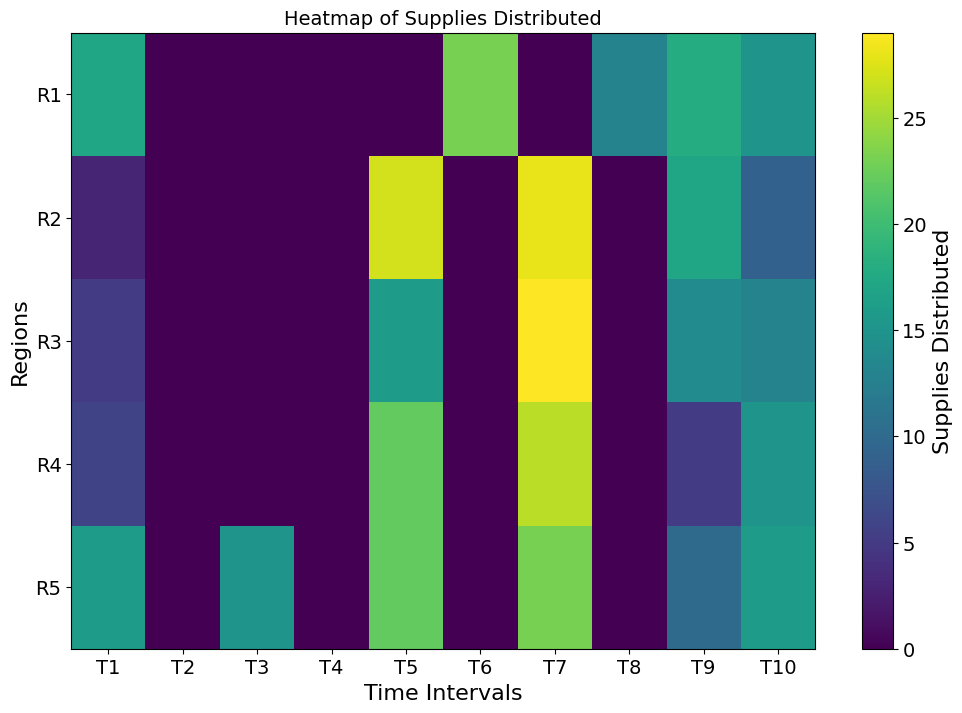

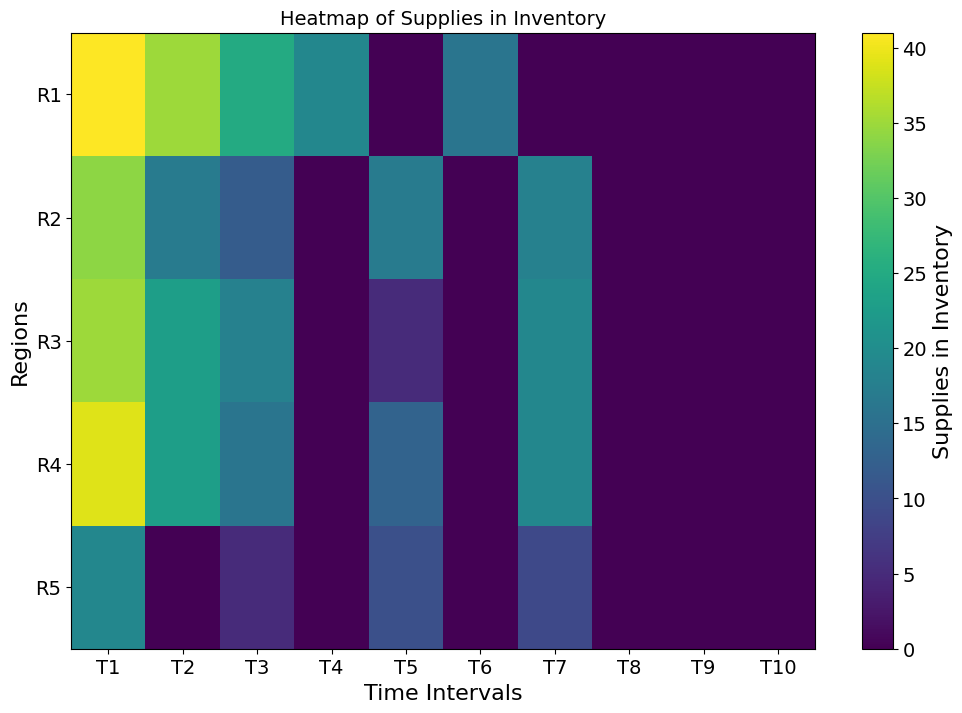

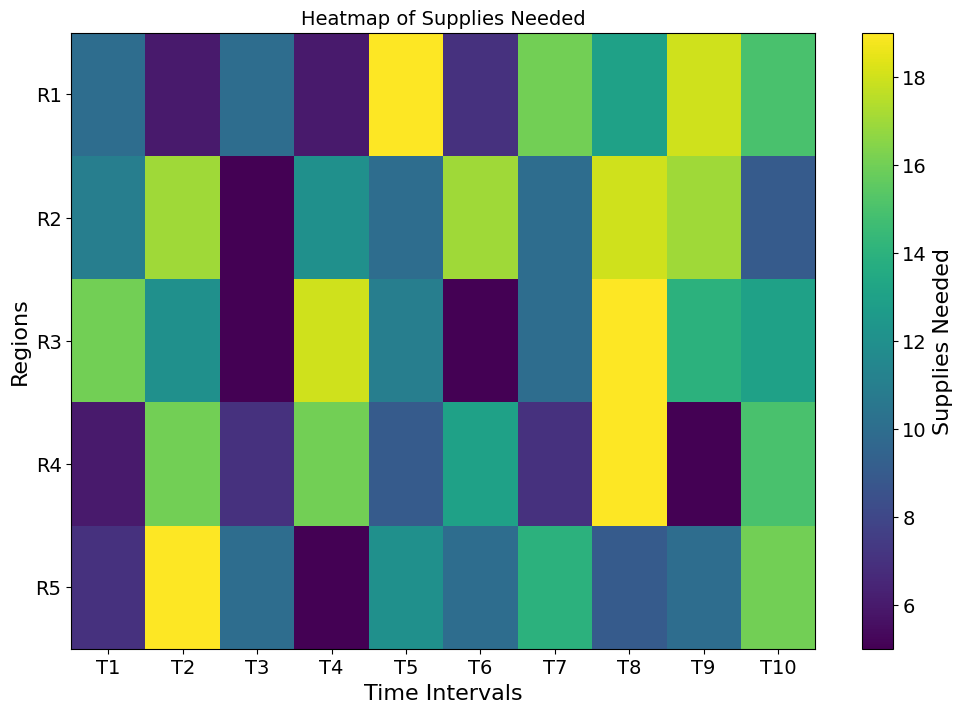

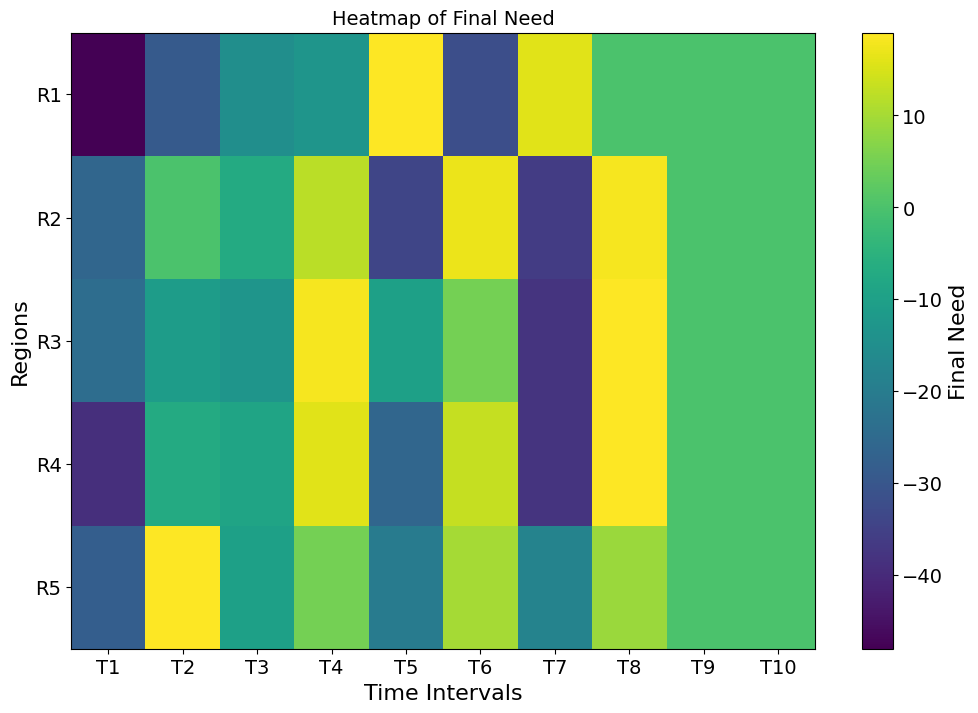

In [21]:
#testing for supplies distribution
N_R = 5  #num of regions
N_t = 10  #num of time intervals
S_needed_data = {(k, t): np.random.randint(5, 20) for k in range(1, N_R + 1) for t in range(1, N_t + 1)}
d_data = {(k, t): np.random.random() for k in range(1, N_R + 1) for t in range(1, N_t + 1)}
p_data = {k: float(np.random.random()) for k in range(1, N_R + 1)}
I_initial_data = {k: np.random.randint(10, 50) for k in range(1, N_R + 1)}


model = m_model(S_needed_data, d_data, p_data, I_initial_data, N_t=N_t, N_R=N_R)

supplies_distributed = plot_heatmap(dist_array, model)
inventory = plot_heatmap(inventory_array, model)
needed = plot_heatmap(needed_array, model)
final = plot_heatmap(final_array, model)


**Supplies Distributed**: The heatmap reveals a highly dynamic allocation of supplies across regions and time intervals. Certain regions and times received significantly higher distributions (indicated by bright yellow areas), which align with periods of elevated need or prioritization. This suggests that critical demands were met in these instances. However, some regions consistently received lower supplies, which highlights areas with reduced urgency or lower demand levels.

**Supplies in Inventory**: The inventory heatmap shows that supplies in stock decrease sharply in regions and times of high distribution activity. On the other hand, regions with less immediate demand or lower prioritization maintain higher inventory levels.

**Supplies Needed**: The supplies needed heatmap confirms the variability of demand across regions and time intervals. The bright areas (indicating higher needs) coincide with regions and times that received higher supplies in the distribution heatmap. This alignment suggests the system's responsiveness to actual demand. However, the scattered bright areas also highlight that demand is not uniform.

**Final Need**: The heatmap of final unmet need reveals areas where the model succeeded in meeting demand (dark regions) versus areas with residual unmet need (lighter regions). In most cases, unmet needs are minimal, indicating efficient resource allocation. However, regions with persistent lighter areas highlight potential gaps in distribution, which could be due to constraints like supply limits or prioritization criteria.

##Sensitivity Analysis - Monte Carlo Simulation

This project employs Monte Carlo simulations to explore the variability and sensitivity of our disaster response model across a range of different possible scenarios. This involves randomly varying key input parameters—such as supply needs, danger levels, and resource availability—within predefined ranges to mimic realistic conditions.

In [22]:
import numpy as np
import plotly.express as px

N_R = 5  #num of regions
N_t = 10  #num of time intervals

# Number of simulations
n_simulations = 100

# Define the ranges for random sampling
S_needed_range = (5, 20)
d_range = (0, 1)  # assuming uniform random between 0 and 1
p_range = (0, 1)
I_initial_range = (10, 50)

# Store results
sensitivity_results = []
results_std = []
# Perform Monte Carlo simulations
for _ in range(n_simulations):
    # Sample random values for each parameter
    S_needed_data = {(k, t): np.random.randint(*S_needed_range) for k in range(1, N_R + 1) for t in range(1, N_t + 1)}
    d_data = {(k, t): np.random.random() for k in range(1, N_R + 1) for t in range(1, N_t + 1)}
    p_data = {k: np.random.random() for k in range(1, N_R + 1)}
    I_initial_data = {k: np.random.randint(*I_initial_range) for k in range(1, N_R + 1)}

    # Run the model with the sampled inputs
    model = m_model(S_needed_data, d_data, p_data, I_initial_data, N_t=N_t, N_R=N_R)

    # Extract the output of interest (e.g., supplies final)

    final = np.array([[pyo.value(model.S[k, t]) - pyo.value(model.I[k, t]) - pyo.value(model.x[k, t]) for t in range(1, N_t + 1)] for k in range(1, N_R + 1)])

    #use the middle column in final
    col = final[:, N_t // 2]
    # Save some statistic (e.g., mean of the supplies final)
    sensitivity_results.append(np.mean(col))
    results_std.append(np.std(col))
# Analyze the results
fig = px.histogram(x=sensitivity_results, nbins=20, title='Monte Carlo Simulation: Sensitivity Analysis of Supplies State')
#make the bars thinner
fig.update_traces(marker_line_width=0.5)
#fig.update_layout(bargap=0.2)
fig.show()
##send the text output to another

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /root/.idaes/bin/cbc -printingOptions all -import /tmp/tmpnntxeltw.pyomo.lp -stat=1 -solve -solu /tmp/tmpnntxeltw.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-250) rows, 0 (-151) columns and 0 (-395) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 23530 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0 (-250) rows, 0 (-151) columns and 0 (-395

In [23]:
fig = px.histogram(x=sensitivity_results, nbins=20, title='Monte Carlo Simulation: Sensitivity Analysis of Supplies State: Means')
#make the bars thinner
fig.update_traces(marker_line_width=0.5)
#fig.update_layout(bargap=0.2)
fig.show()

In [24]:
fig_s = px.histogram(x=results_std, nbins=20, title='Monte Carlo Simulation: Sensitivity Analysis of Supplies State: Standard Deviataion')
#make the bars thinner
fig_s.update_traces(marker_line_width=0.5)
#fig.update_layout(bargap=0.2)
fig_s.show()

Means of the results: -4.084
Standard deviations of the results: 9.332402906004434


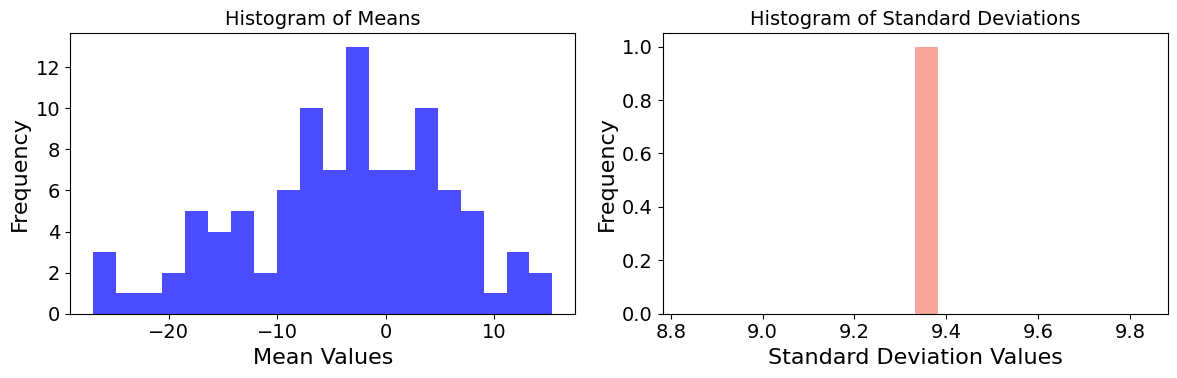

In [25]:
sensitivity_results = np.array(sensitivity_results)

#Calculate the mean and the standard deviation
means = np.mean(sensitivity_results, axis=0)
std_devs = np.std(sensitivity_results, axis=0)

print(f"Means of the results: {means}")
print(f"Standard deviations of the results: {std_devs}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(sensitivity_results, bins=20, color='blue', alpha=0.7)
ax1.set_title('Histogram of Means')
ax1.set_xlabel('Mean Values')
ax1.set_ylabel('Frequency')

ax2.hist(std_devs, bins=20, color='salmon', alpha=0.7)
ax2.set_title('Histogram of Standard Deviations')
ax2.set_xlabel('Standard Deviation Values')
ax2.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

To validate the model, this sensitivity analysis was conducted through utilizing Monte Carlo simulations. The result reveals the variability in the average supplies distributed across regions and time intervals under uncertain input parameters such as supply needs, danger levels, positional priorities, and initial inventories. The histogram of results highlights a distribution centered near zero. This indicates that, on average, the optimization model balances supply and demand effectively. However, the spread of the results reflects the influence of random fluctuations in the parameters, suggesting that certain scenarios may lead to significant deviations in supplies allocated to regions. This variability underscores the significance of robust planning in disaster response scenarios, where uncertainties in demand, resource availability, and prioritization can significantly impact the overall system performance.

##Discussion

This

Through this example, we were able to go beyond the reference material, by creating a new and unique application of the optimization problem. By applying this to a real life situation, we were able to create a simplified model to represent a real life situation that could be expanded to create real social good.